In [36]:
from lsst.pipe.tasks.imageDifference import ImageDifferenceTask
import lsst.afw.display as afwDisplay
from lsst.daf.butler import Butler
import matplotlib.pyplot as plt
import lsst.geom
import astropy.units as u 
import lsst.afw.image as afwImage
from astropy.coordinates import SkyCoord

from astropy import units as u
from astropy.time import Time
import numpy as np
import pandas as pd

import sep
import os
from astropy.io import fits
#from lsst.ip.diffim.ZogyConfig 

In [7]:
#butler.queryMetadata('deepDiff_differenceExp', ('visit'), dataId={'filter': 'g'})[:10]

## Functions to manage and plot the exposures from LSST Science Pipelines

In [2]:
def get_all_exposures(repo, obs_type, instrument='DECam'):
    """
    Gets all the calibrated exposure from a butler REPO as a pandas DataFrame
    
    -----
    Input
    -----
    repo : [string] directory of the butler repository
    obs_type : [string] Observation type of the image
    intrument : [string] Name of the instrument, by default 'DECam'
    -----
    Output
    -----
    data : [pd.DataFrame] Dataframe with columns: exposure, target_name, ra, dec, day_obs
    """
    butler = Butler(repo)
    registry = butler.registry
    exposures = []
    data=pd.DataFrame(columns =['exposure','target_name', 'ra', 'dec', 'day_obs'])
    for ref in registry.queryDimensionRecords('exposure',where="instrument='{}' AND exposure.observation_type='{}'".format(instrument,obs_type)):
        exposures.append(ref.dataId['exposure'])
        new_row = [ref.dataId['exposure'], ref.target_name, ref.tracking_ra, ref.tracking_dec, ref.day_obs]
        data.loc[len(data.index)] = new_row
    if data.empty:
        print("No exposure found in REPO:{} with observation type {}".format(repo, obs_type))
    return data

In [3]:
def radec_to_pixel(ra,dec,wcs):
    """
    Retrieves the x,y pixel position of a coordinate ra,dec given the wcs of the image.
    
    -----
    Input
    -----
    ra : [float] right ascention coordinate in decimal degrees
    dec : [float] declination coordinate in decimal degrees
    wcs : [lsst.afw.geom.SkyWcs] Sky wcs of a product image from the LSST Science Pipelines
    -----
    Output
    -----
    x_pix : [float] x pixel position
    y_pix : [float] y pixel position
    """
    obj_pos_lsst = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)
    return x_pix, y_pix

In [4]:
def Calib_and_Diff_plot(repo, collection_diff, collection_calexp, ra, dec, visits, ccd_num):
    """
    Plots the calibrated and difference-imaged exposure
    -----
    Input
    -----
    repo : [string] directory of the butler repository 
    collection_diff : [string] name of the difference imaging collection
    collection_calexp : [string] name of the calibrated exposures collection
    ra : [float] right ascention coordinate in decimal degrees
    dec : [float] declination coordinate in decimal degrees
    visits : [ndarray] list of visits
    ccd_num : [int] number of the DECam detector
    -----
    Output
    -----
    None
    
    """
    if visits==[]:
        print("No visits submitted")
        return
    butler = Butler(repo)
    for i in range(len(visits)):
        #i = 7 # index of visit
        calexp = butler.get('calexp', visit= visits[i], detector= ccd_num, instrument='DECam', collections=collection_calexp)
        calexp_im = calexp.getMaskedImage()
        calexp_cat = butler.get('src', visit= visits[i], detector= ccd_num, instrument='DECam', collections=collection_calexp)

        diffexp = butler.get('goodSeeingDiff_differenceExp',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
        diffexp_cat = butler.get('goodSeeingDiff_diaSrc',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
        diffexp_im = diffexp.getMaskedImage()

        afwDisplay.setDefaultMaskTransparency(100)
        afwDisplay.setDefaultBackend('matplotlib')


        fig = plt.figure(figsize=(16, 14))
        imag_display = []

        fig.add_subplot(1,2,1)
        imag_display.append(afwDisplay.Display(frame=fig))
        imag_display[0].scale('linear', 'zscale')
        imag_display[0].mtv(calexp_im)
        plt.title("Calibrated exposure", fontsize=17)

        fig.add_subplot(1,2,2)
        imag_display.append(afwDisplay.Display(frame=fig))
        imag_display[1].scale('linear', 'zscale')
        #display[1].setMaskTransparency(10)
        imag_display[1].mtv(diffexp_im)
        plt.title("Subtracted exposure", fontsize=17)

        x_pix, y_pix = radec_to_pixel(ra, dec, diffexp.getWcs())

        imag_display[1].dot('o', x_pix, y_pix, ctype='magenta', size=20)

        for src in diffexp_cat:
            imag_display[1].dot('o', src.getX(), src.getY(), ctype='cyan', size=30)
        plt.tight_layout()
        plt.show()
    return

In [24]:
def Calib_and_Diff_plot_cropped(repo, collection_diff, collection_calexp, ra, dec, visits, ccd_num):
    """
    Plots the calibrated and difference-imaged exposure cropped to the location of ra,dec
    -----
    Input
    -----
    repo : [string] directory of the butler repository 
    collection_diff : [string] name of the difference imaging collection
    collection_calexp : [string] name of the calibrated exposures collection
    ra : [float] right ascention coordinate in decimal degrees
    dec : [float] declination coordinate in decimal degrees
    visits : [ndarray] list of visits
    -----
    Output
    -----
    None
    
    """
    if visits==[]:
        print("No visits submitted")
        return
    butler = Butler(repo)
    for i in range(len(visits)):
        obj_pos_lsst = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
        calexp = butler.get('calexp', visit= visits[i], detector= ccd_num, instrument='DECam', collections=collection_calexp)
        calexp_im = calexp.getMaskedImage()
        calexp_cat = butler.get('src', visit= visits[i], detector= ccd_num, instrument='DECam', collections=collection_calexp)
        
        diffexp = butler.get('goodSeeingDiff_differenceExp',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
        diffexp_cat = butler.get('goodSeeingDiff_diaSrc',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
        #diffexp_im = diffexp.getMaskedImage()
        #print(diffexp.get¡)
                 
        afwDisplay.setDefaultMaskTransparency(100)
        afwDisplay.setDefaultBackend('matplotlib')
        wcs = diffexp.getWcs()
        x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)
        x_half_width = 40
        y_half_width = 40
        bbox = lsst.geom.Box2I()
        bbox.include(lsst.geom.Point2I(x_pix - x_half_width, y_pix - y_half_width))
        bbox.include(lsst.geom.Point2I(x_pix + x_half_width, y_pix + y_half_width))

        calexp_cutout = calexp.getCutout(obj_pos_lsst, size=lsst.geom.Extent2I(80, 80))
        diffexp_cutout = diffexp.getCutout(obj_pos_lsst, size=lsst.geom.Extent2I(80, 80))

        fig = plt.figure(figsize=(10, 5))
        stamp_display = []

        fig.add_subplot(1,2,1)
        stamp_display.append(afwDisplay.Display(frame=fig))
        stamp_display[0].scale('linear', 'zscale')
        #print(type(diffexp_cutout.maskedImage))
        #print(diffexp_cutout.maskedImage)
        print(visits[i])
        stamp_display[0].mtv(calexp_cutout.maskedImage)
        print(stamp_display[0].mtv(calexp_cutout.maskedImage))
        stamp_display[0].dot('o', x_pix, y_pix, ctype='magenta', size=4)
        #stamp_display[0].dot('o', x_pix, y_pix, size=4)
        for src in calexp_cat:
            stamp_display[0].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
        plt.title('Calexp Image and Source Catalog')

        fig.add_subplot(1,2,2)
        stamp_display.append(afwDisplay.Display(frame=fig))
        stamp_display[1].scale('linear', 'zscale')
        stamp_display[1].mtv(diffexp_cutout.maskedImage)


        stamp_display[1].dot('o', x_pix, y_pix, ctype='magenta', size=4)

        #stamp_display[1].dot('o', x_pix, y_pix, size=4)
        for src in diffexp_cat:
            stamp_display[1].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
            #print(src.getX(), src.getY())
        plt.title('Diffexp Image and Source Catalog')

        plt.tight_layout()
        plt.show()
    return

## Using the functions above :)

# Supernovae ...

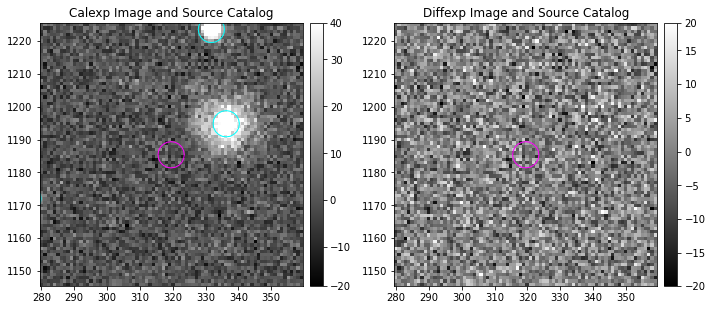

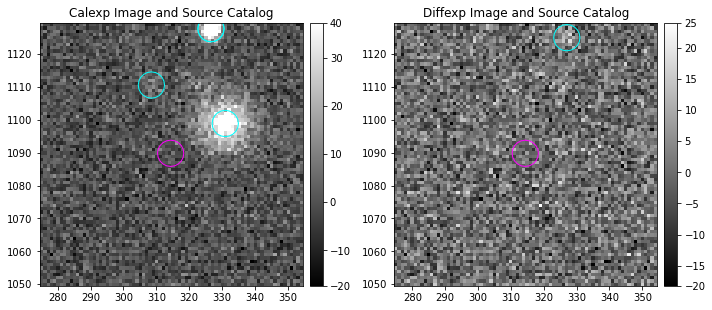

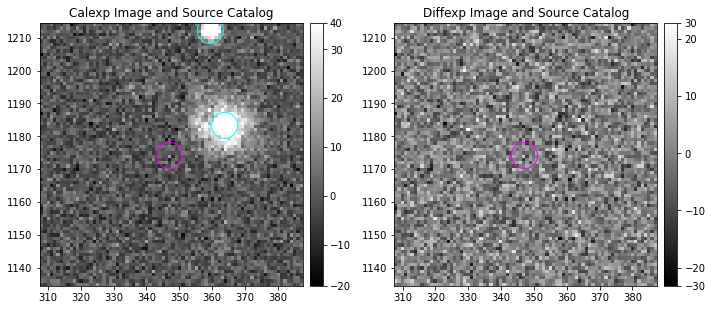

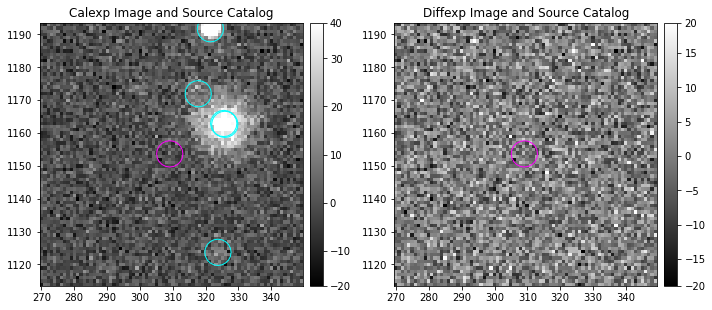

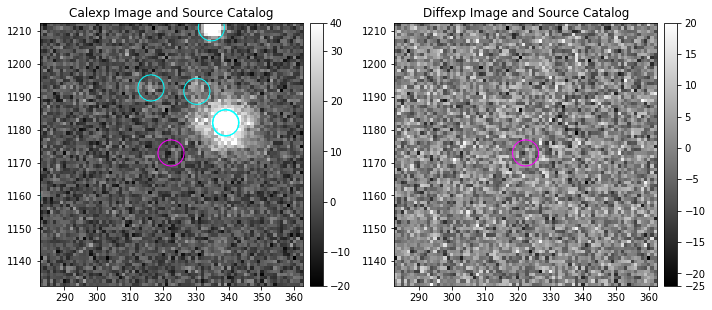

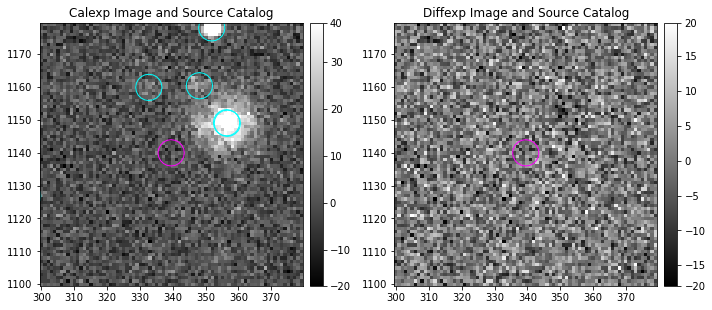

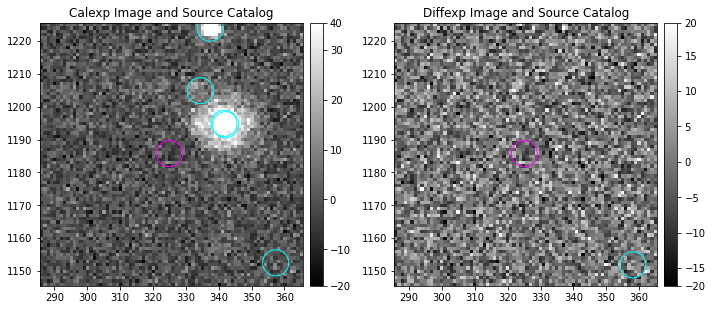

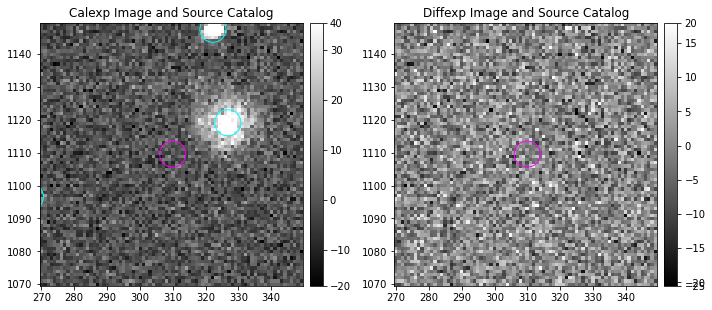

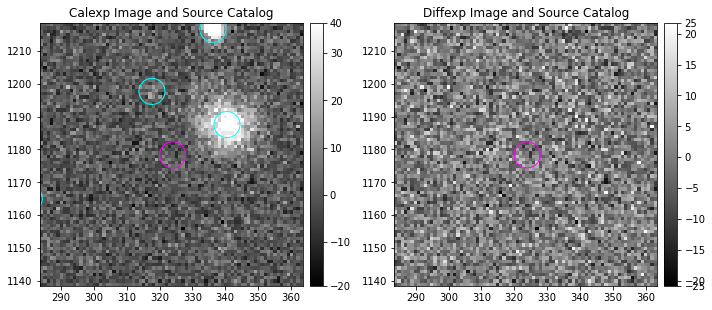

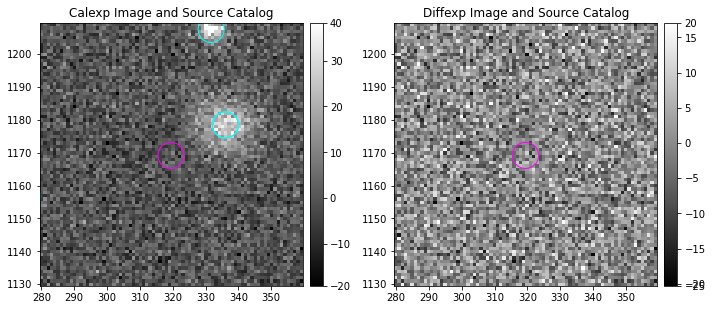

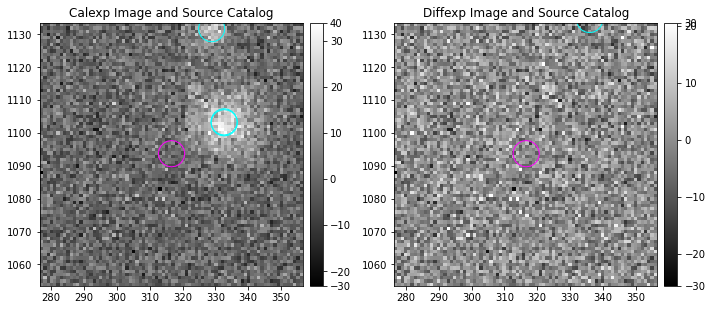

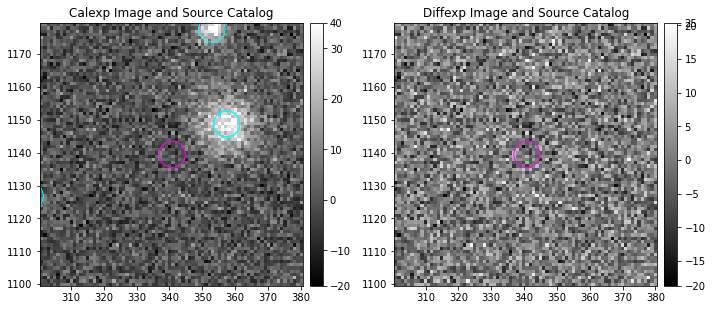

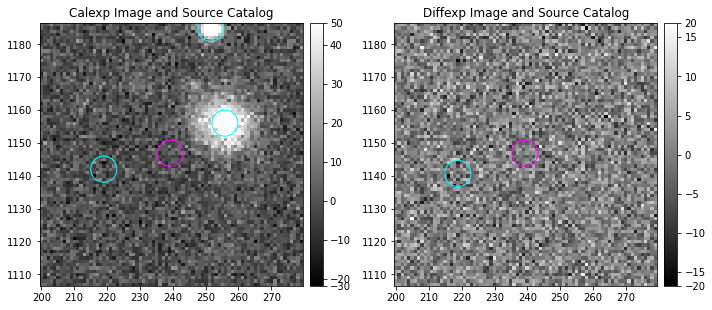

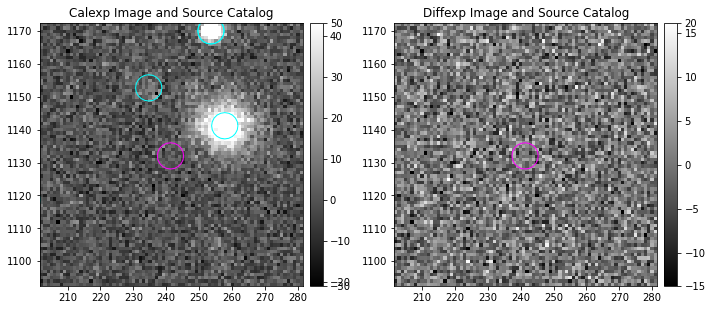

In [8]:
repo = "/home/jahumada/data_hits"
data = get_all_exposures(repo, 'science')
field = "Blind15A_25"
visits = list(data[(data['target_name']=='{}'.format(field)) & (data['day_obs']!=20150219)].exposure)
collection_diff = "imagDiff_SNe/{}".format(field)#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/{}".format(field)
ra_agn, dec_agn = 147.33335283600002, 2.12120902375
ra_sne, dec_sne = 147.244, 2.13481

ra = ra_sne
dec = dec_sne
ccdnum=34
Calib_and_Diff_cropped_plot(repo, collection_diff, collection_calexp, ra, dec, visits, ccdnum)

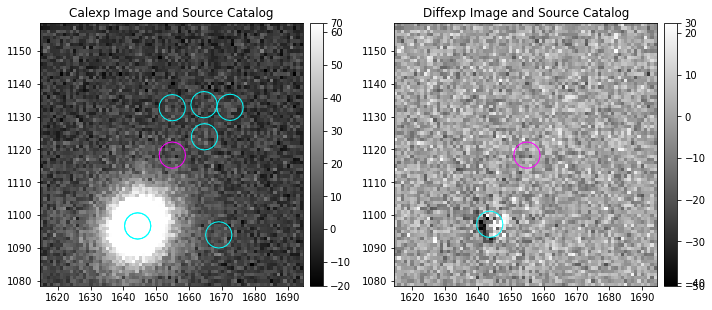

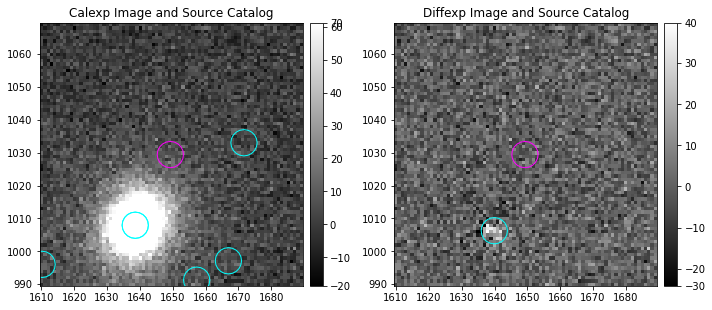

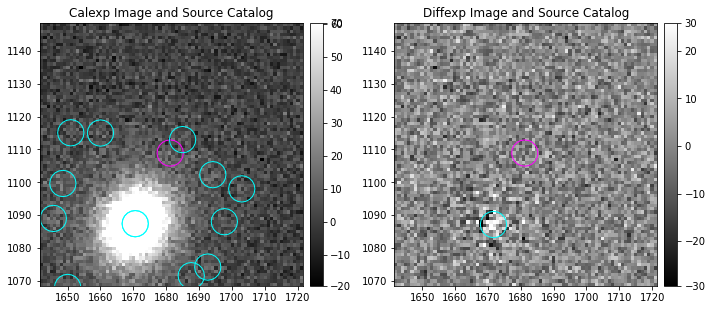

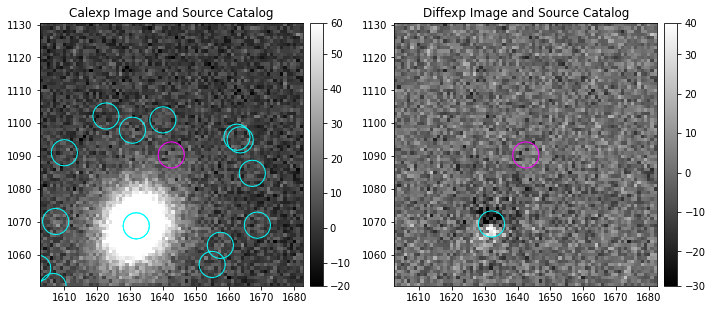

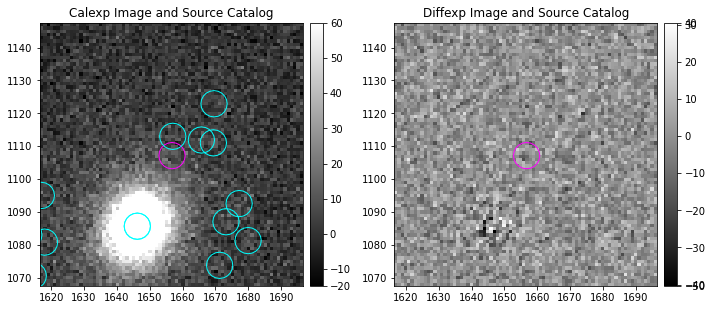

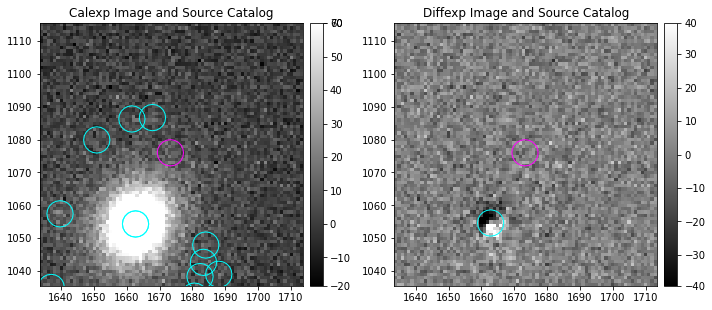

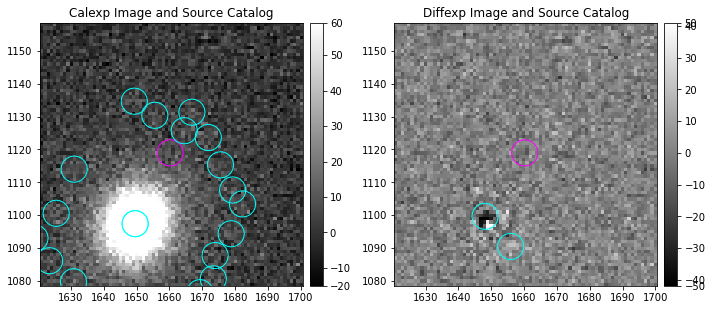

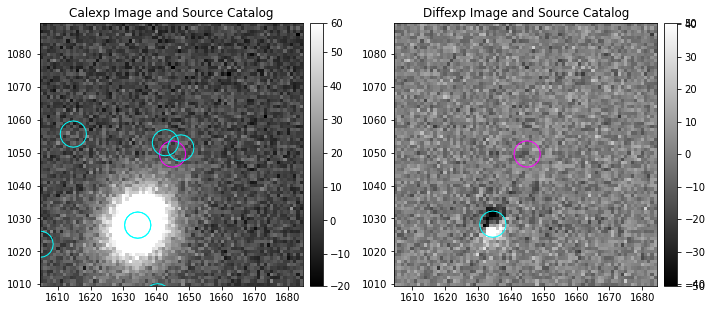

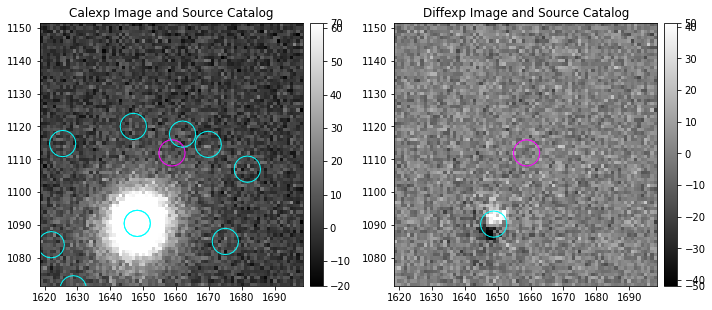

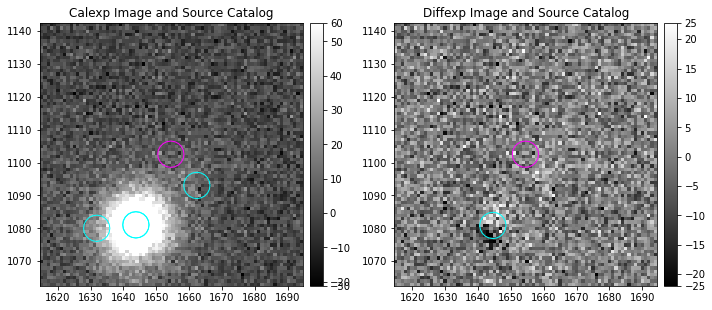

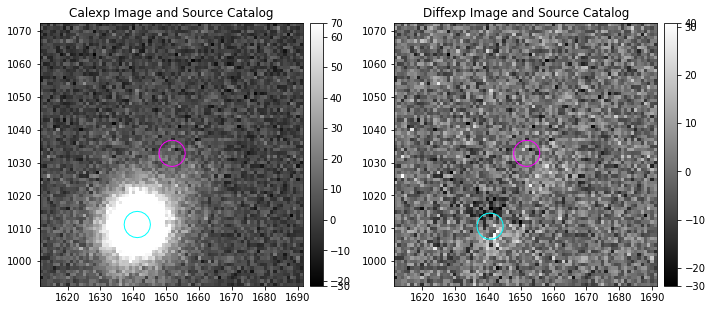

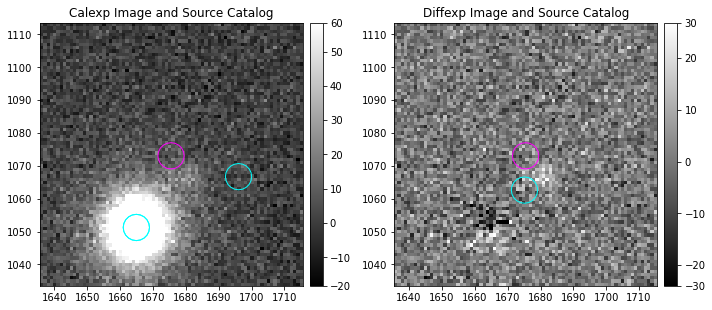

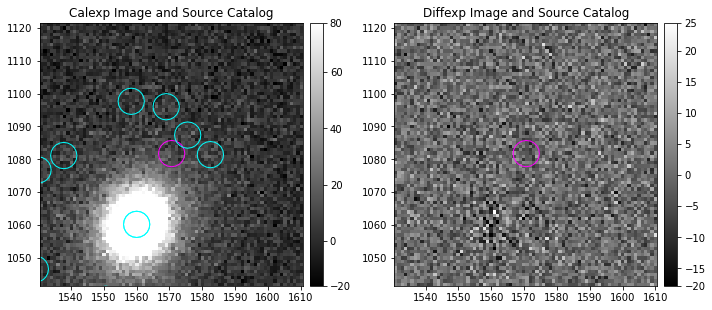

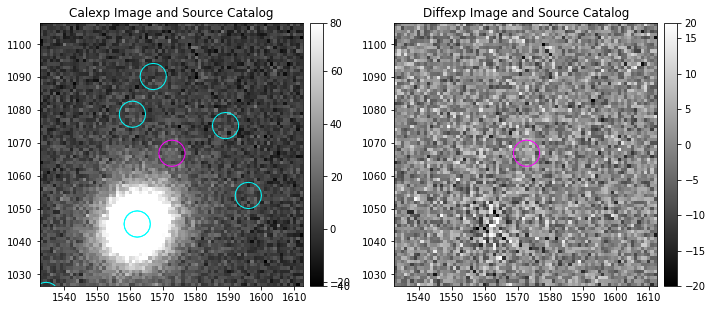

In [10]:
repo = "/home/jahumada/data_hits"
collection_diff = "imagDiff_SNe/Blind15A_25"#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/Blind15A_25"
#ra_agn, dec_agn = 147.33335283600002, 2.12120902375 # ccdnum=34
#ra_sne, dec_sne = 147.244, 2.13481 # ccdnum=34
ra_agn, dec_agn = 146.749741152, 2.56140797566
ra_sne, dec_sne = 146.774, 2.53052

ra = ra_sne
dec = dec_sne
ccdnum = 13
Calib_and_Diff_cropped_plot(repo, collection_diff,collection_calexp, ra, dec, visits, ccdnum)

## Classified Variable Source

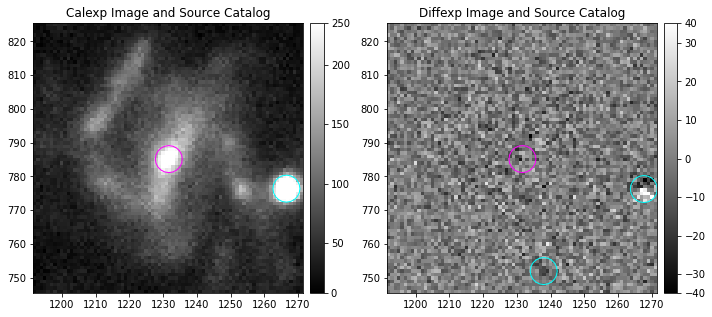

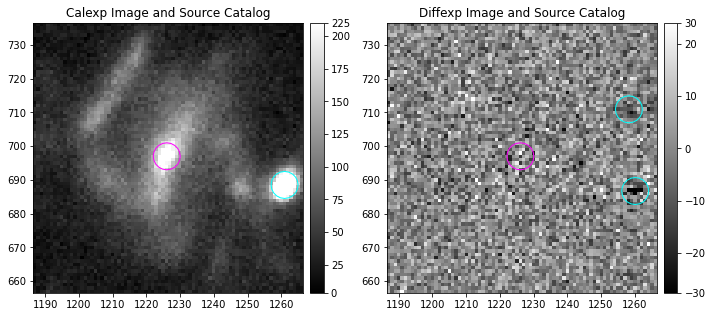

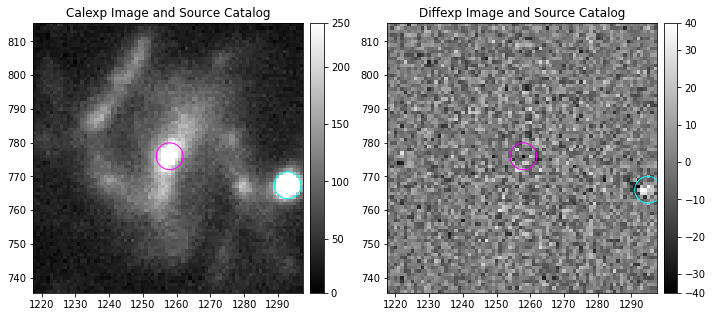

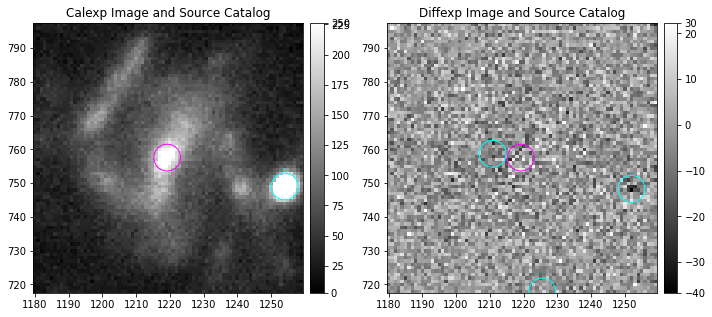

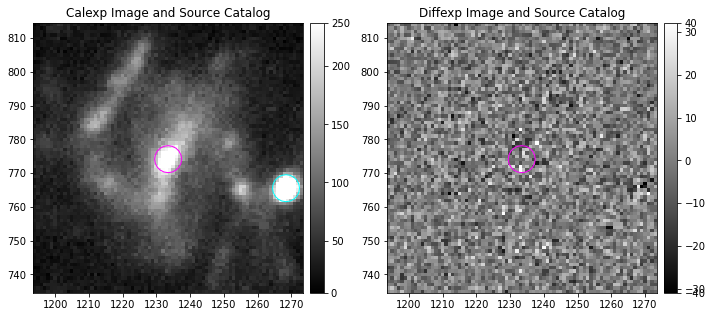

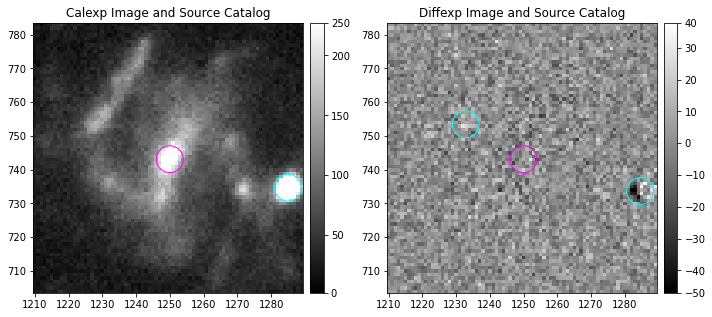

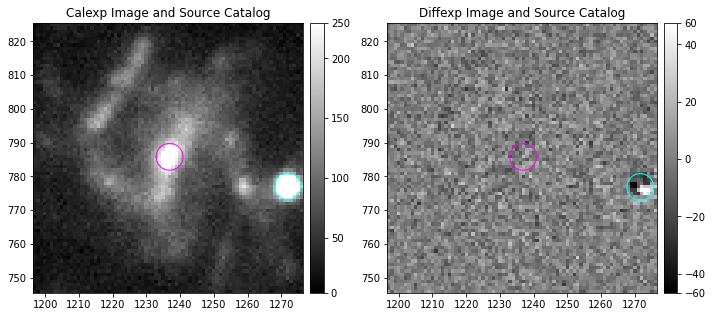

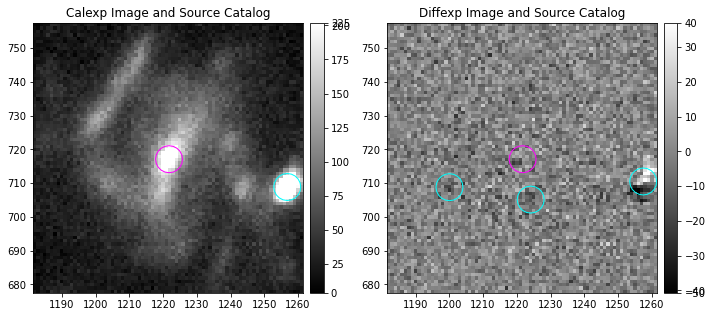

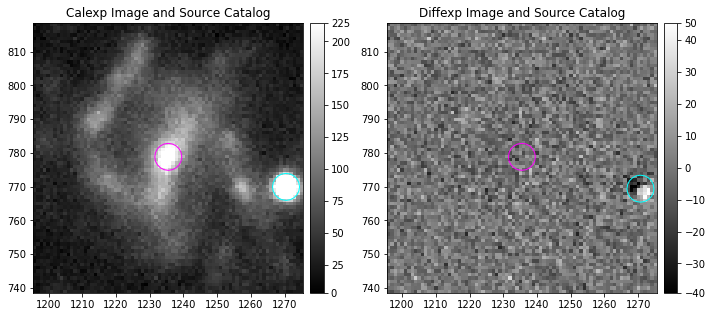

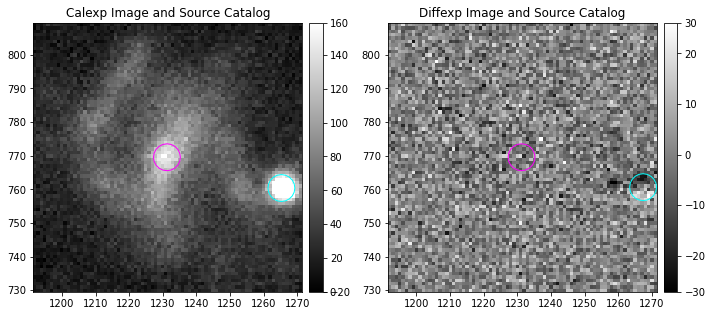

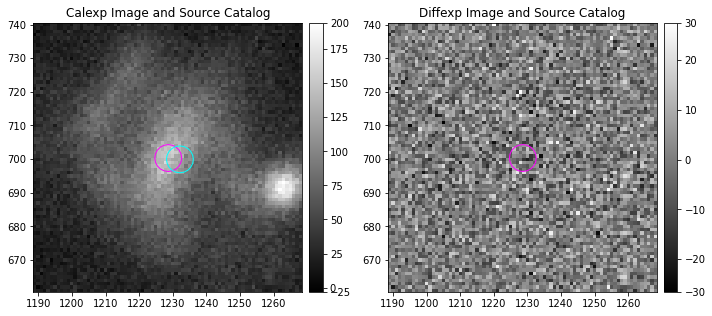

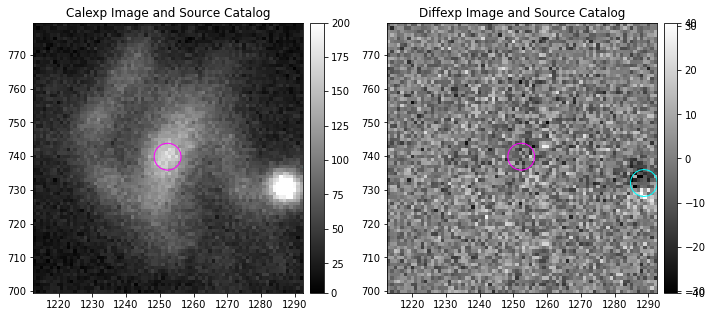

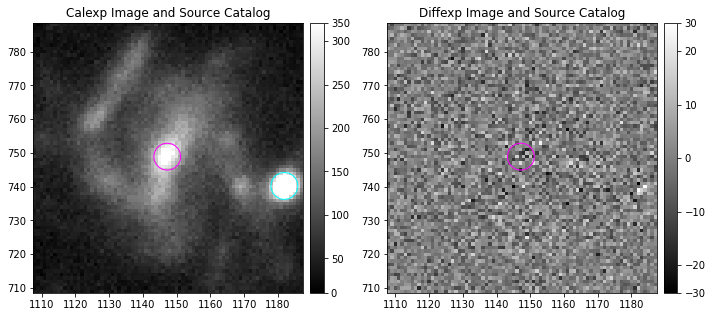

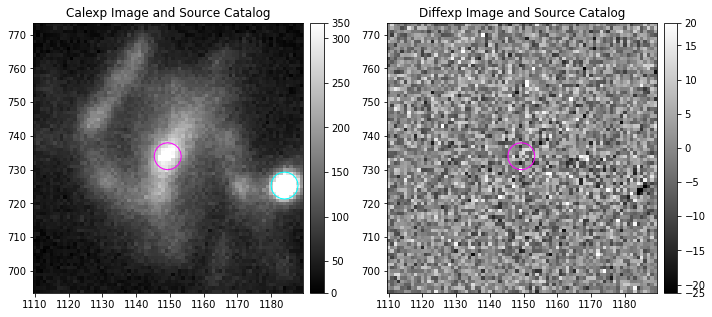

In [37]:
repo = "/home/jahumada/data_hits"
collection_diff = "imagDiff_SNe/Blind15A_25"#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/Blind15A_25"
#ra_agn, dec_agn = 147.33335283600002, 2.12120902375 # ccdnum=34
#ra_sne, dec_sne = 147.244, 2.13481 # ccdnum=34
ra_agn, dec_agn = 146.749741152, 2.56140797566
ra_sne, dec_sne = 146.774, 2.53052

ra = ra_agn
dec = dec_agn
ccdnum = 13
Calib_and_Diff_cropped_plot(repo, collection_diff,collection_calexp, ra, dec, visits, ccdnum)

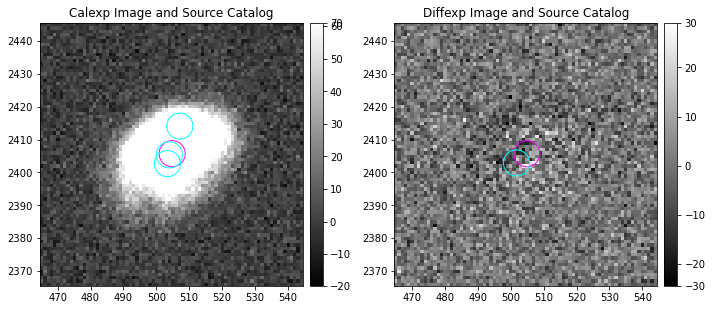

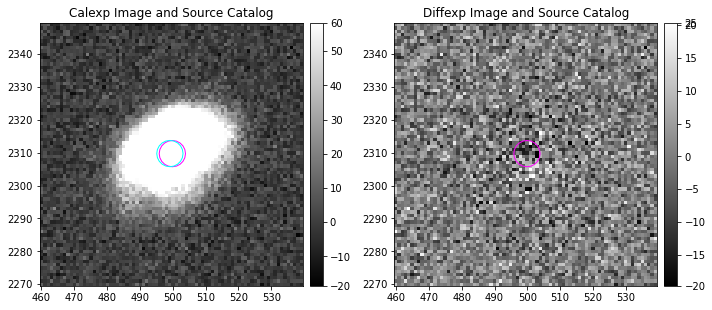

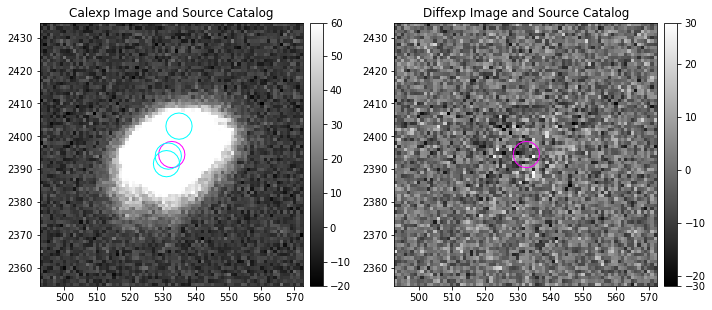

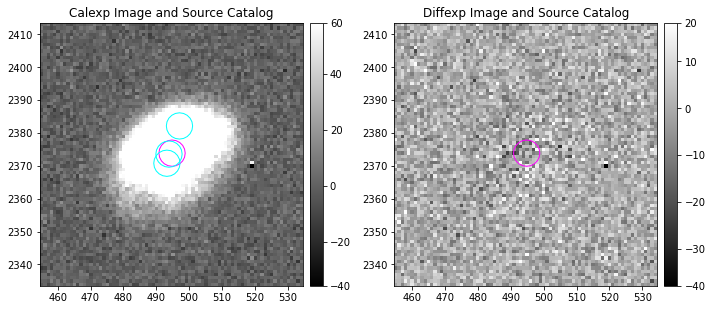

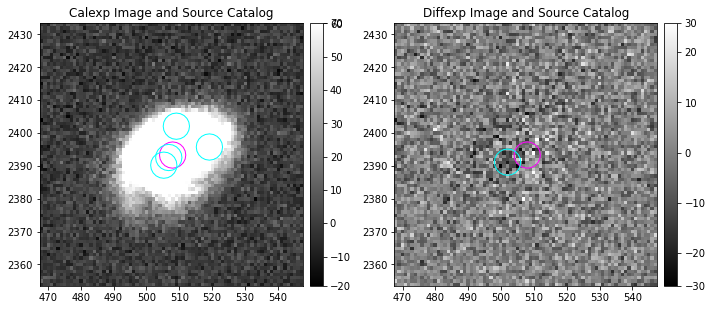

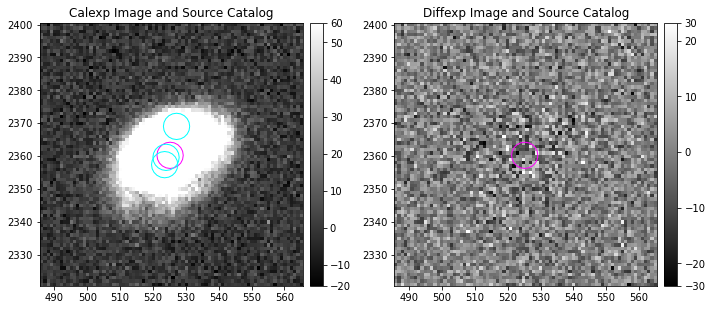

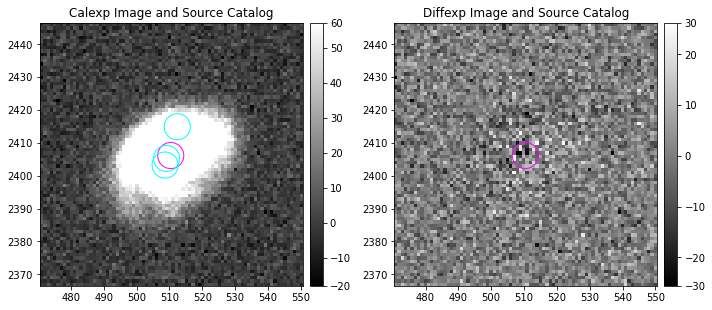

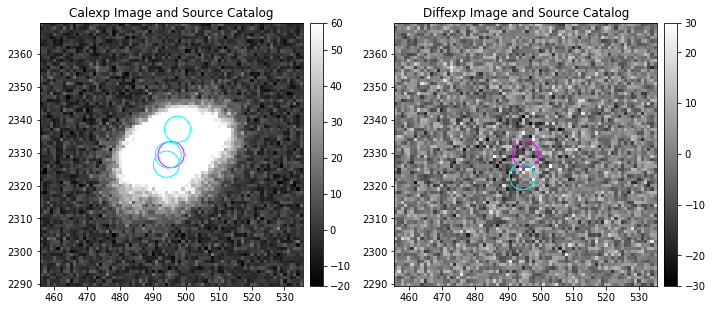

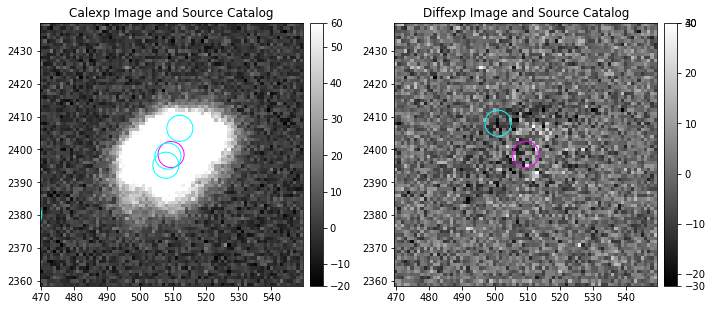

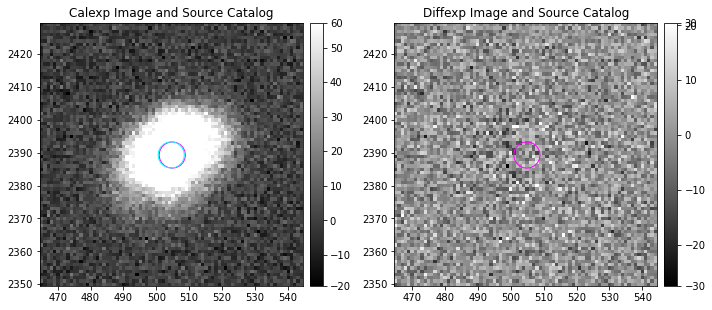

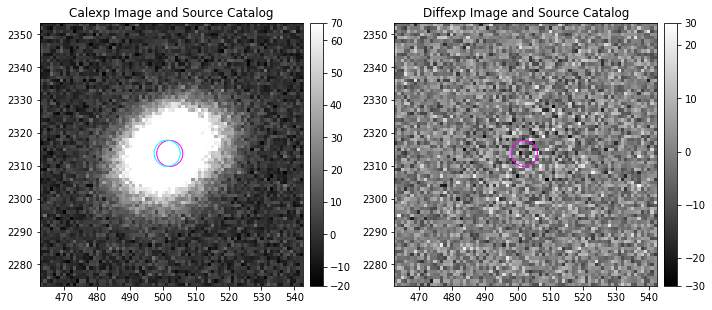

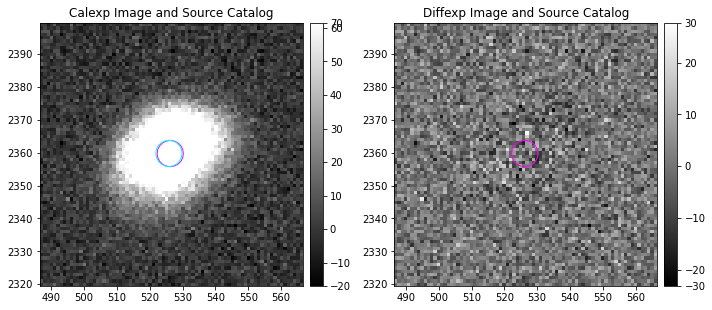

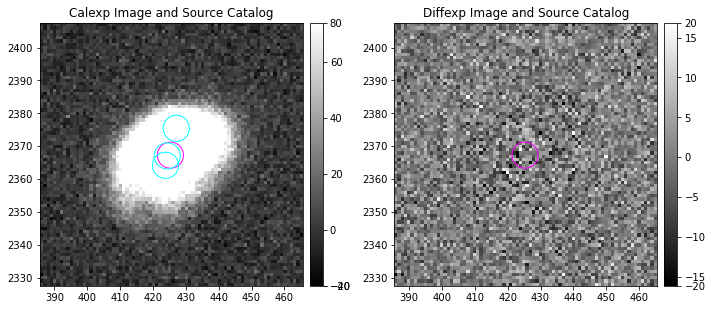

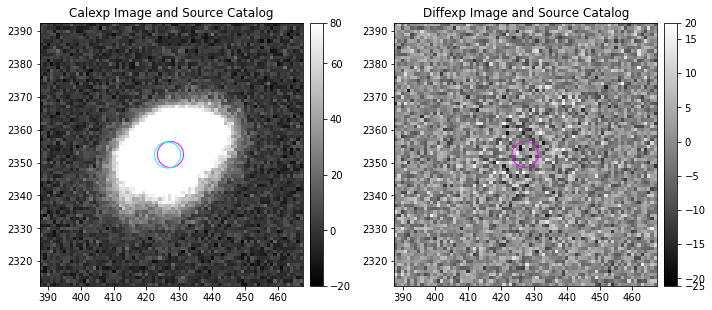

In [7]:
repo = "/home/jahumada/data_hits"
collection_diff = "imagDiff_SNe/Blind15A_25"#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/Blind15A_25"
ra_agn, dec_agn = 147.33335283600002, 2.12120902375 # ccdnum=34
ra_sne, dec_sne = 147.244, 2.13481 # ccdnum=34

ra = ra_agn
dec = dec_agn
ccdnum = 34
Calib_and_Diff_cropped_plot(repo, collection_diff,collection_calexp, ra, dec, visits, ccdnum)

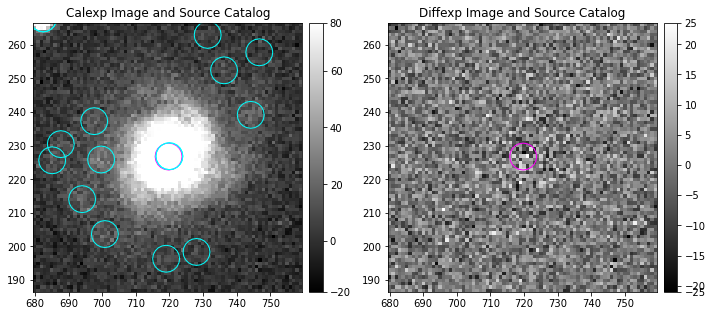

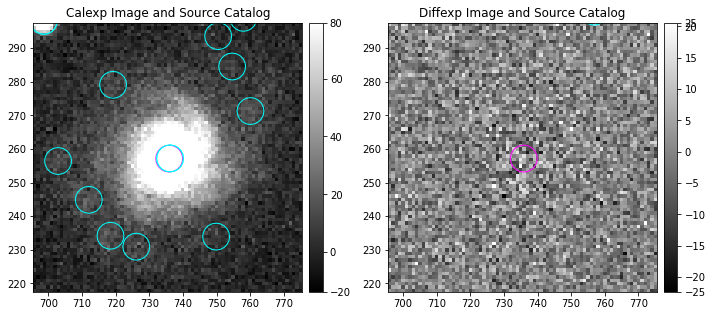

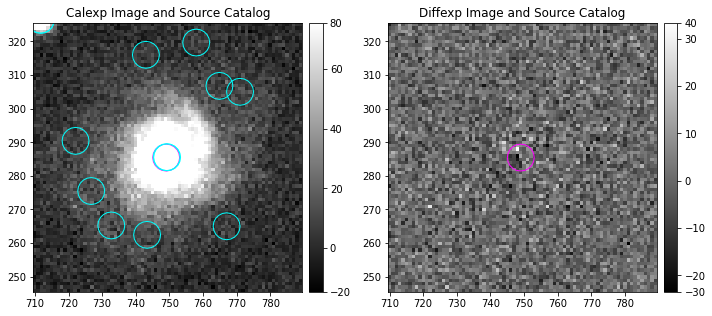

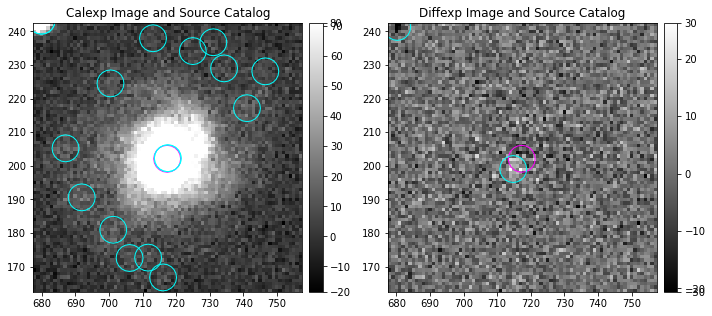

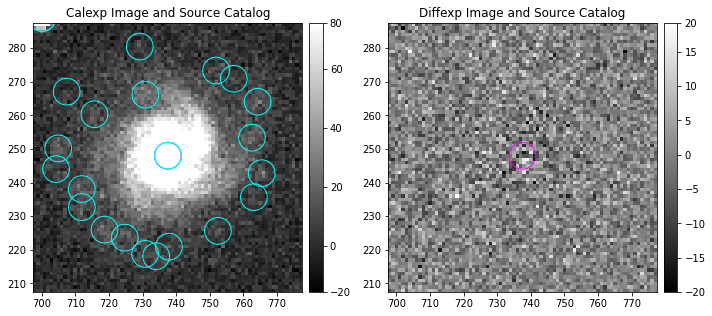

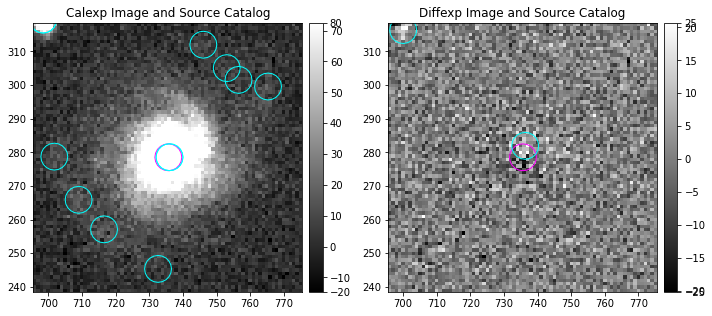

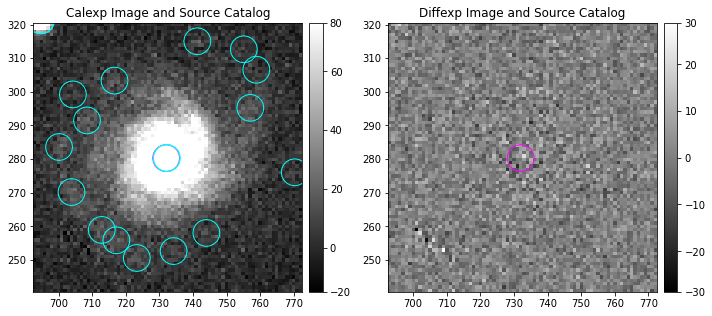

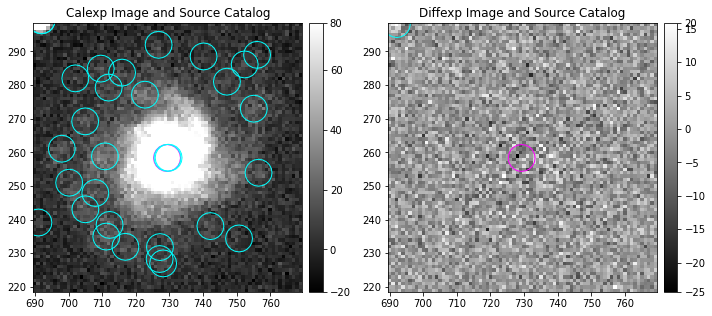

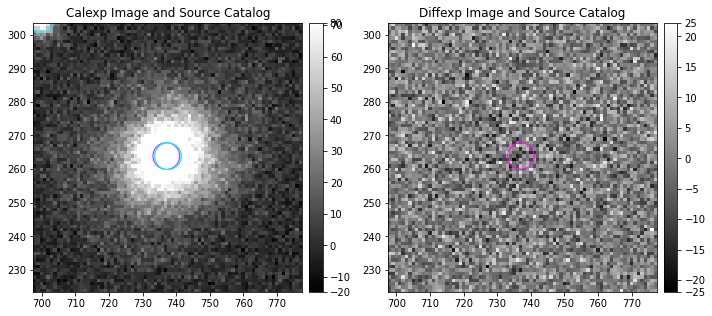

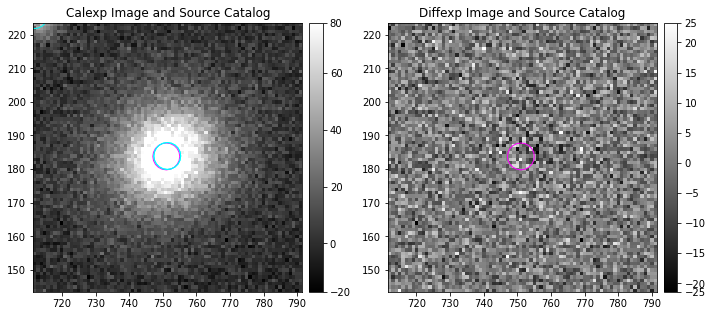

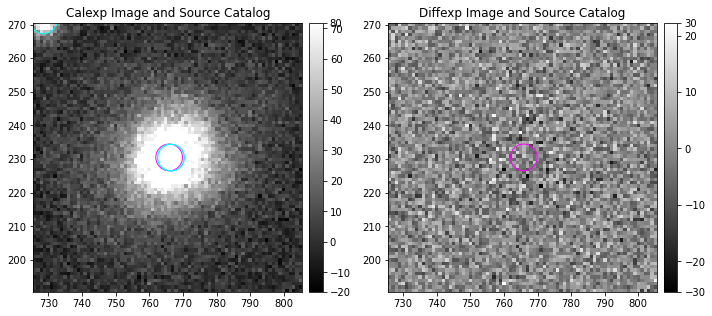

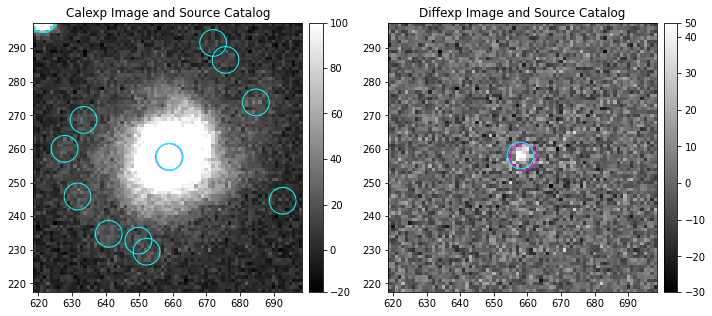

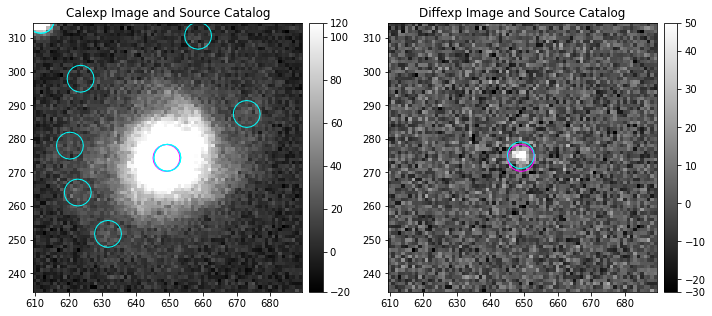

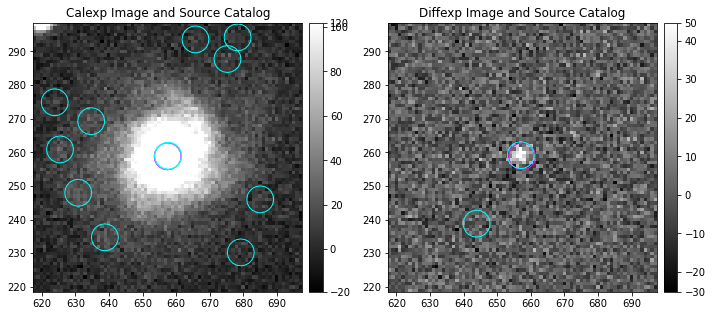

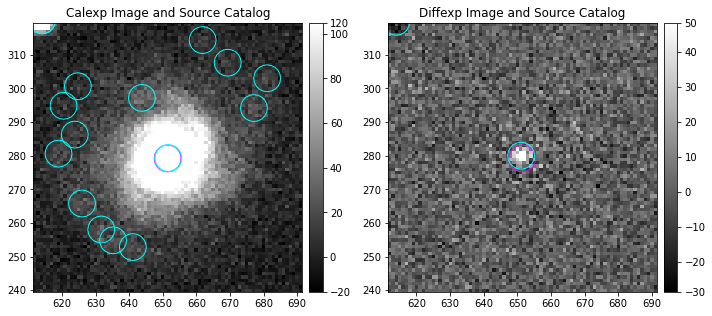

In [42]:
repo = "/home/jahumada/data_hits"
data = get_all_exposures(repo, 'science')
field = "Blind15A_16"
visits = list(data[(data['target_name']=='{}'.format(field)) & (data['day_obs']!=20150219)].exposure)
collection_diff = "imagDiff_AGN/{}".format(field)#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/{}".format(field)
ra_agn, dec_agn = 144.712192037, 1.9721501650400002 
#ra_sne, dec_sne = 147.244, 2.13481

ra = ra_agn
dec = dec_agn
ccdnum=20
Calib_and_Diff_cropped_plot(repo, collection_diff, collection_calexp, ra, dec, visits, ccdnum)

411055
None


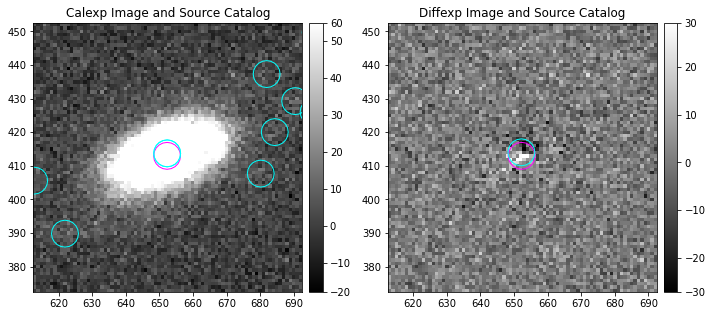

410915
None


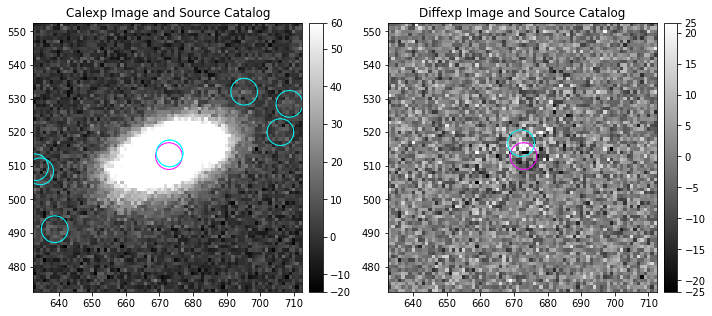

411021
None


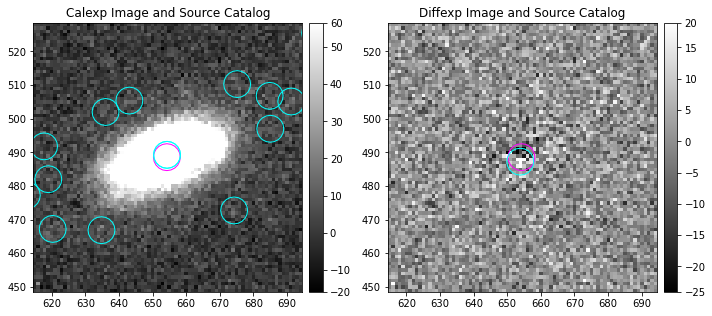

410971
None


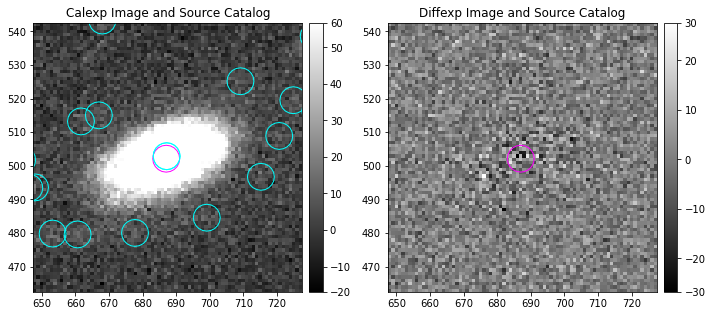

411456
None


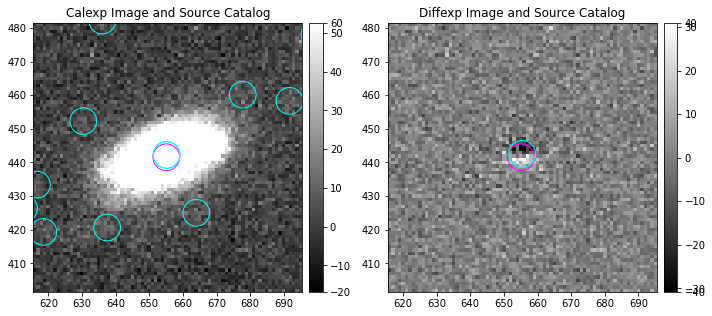

411355
None


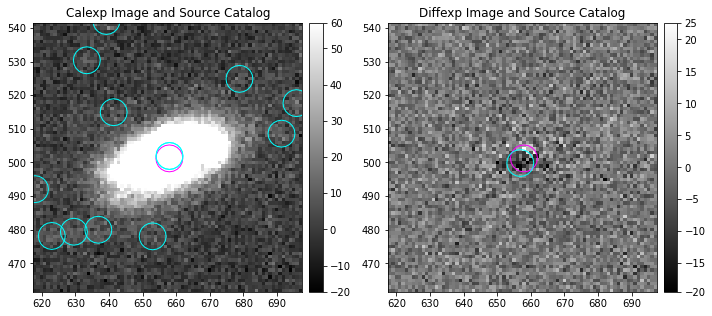

411406
None


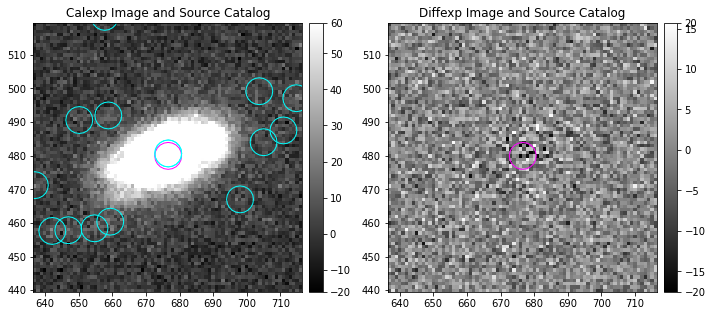

411305
None


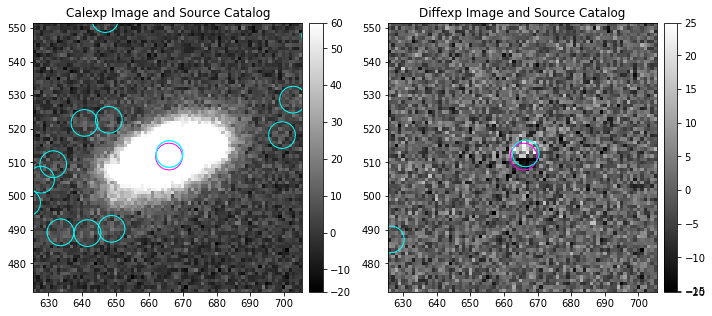

411255
None


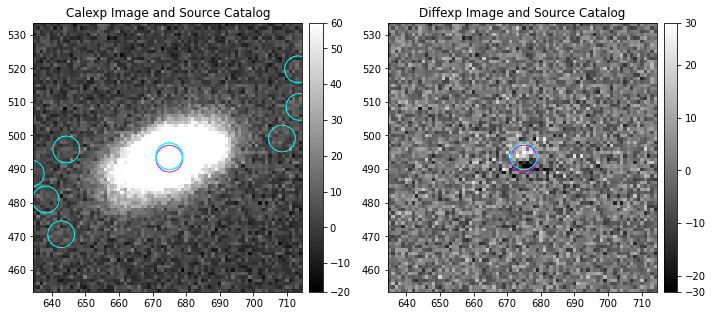

412060
None


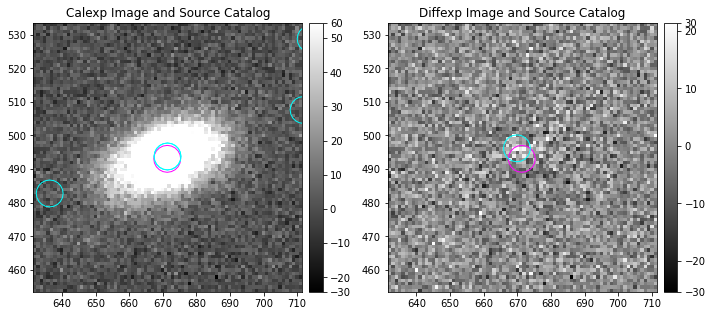

412307
None


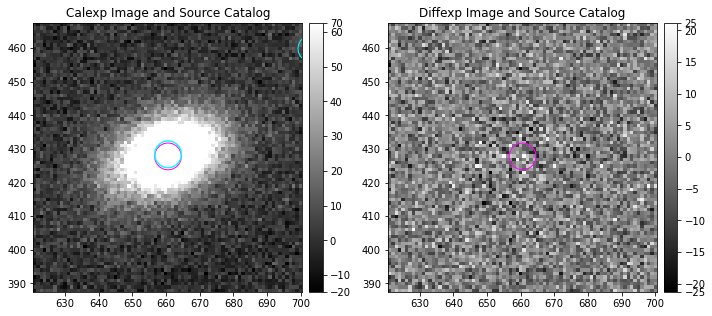

412250
None


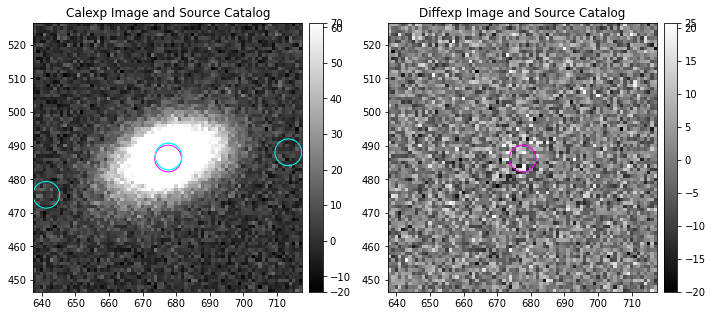

In [25]:
field = "Blind15A_26"
data = get_all_exposures(repo, 'science')
repo = "/home/jahumada/data_hits"
collection_diff = "imagDiff_AGN/{}".format(field)#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/{}".format(field)
visits = list(data[(data['target_name']=='{}'.format(field)) & (data['day_obs']!=20150219)].exposure)
ra_agn, dec_agn = 150.162182239, 1.99157341183
ra = ra_agn
dec = dec_agn
ccdnum = 42
Calib_and_Diff_plot_cropped(repo, collection_diff,collection_calexp, ra, dec, visits, ccdnum)

In [9]:
#repo = "/home/jahumada/data_hits"
#data = get_all_exposures(repo, 'science')
#field = "Blind15A_16"
#visits = list(data[(data['target_name']=='{}'.format(field)) & (data['day_obs']!=20150219)].exposure)
#collection_diff = "imagDiff_AGN/{}".format(field)#02_v6/20220208T080733Z"
#collection_calexp = "processCcdOutputs/{}".format(field)
#ra_agn, dec_agn = 144.410886627, 1.7251189860599998
##ra_sne, dec_sne = 147.244, 2.13481
#
#ra = ra_agn
#dec = dec_agn
#ccdnum=11
#Calib_and_Diff_cropped_plot(repo, collection_diff, collection_calexp, ra, dec, visits, ccdnum)

## Classified Non Variable source

None


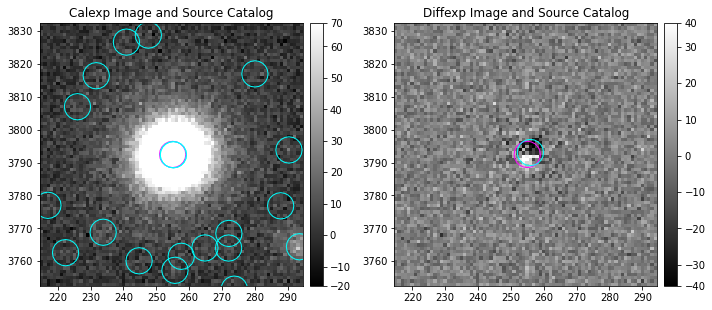

In [15]:
repo = "/home/jahumada/data_hits"
data = get_all_exposures(repo, 'science')
field = "Blind15A_16"
visits = list(data[(data['target_name']=='{}'.format(field)) & (data['day_obs']!=20150219)].exposure)[0:1]
collection_diff = "imagDiff_AGN/{}".format(field)#02_v6/20220208T080733Z"
collection_calexp = "processCcdOutputs/{}".format(field)
ra_agn, dec_agn = 144.66250020799998, 2.0062343839200003
#ra_sne, dec_sne = 147.244, 2.13481

ra = ra_agn
dec = dec_agn
ccdnum=19
Calib_and_Diff_plot_cropped(repo, collection_diff, collection_calexp, ra, dec, visits, ccdnum)

# Aperture fotometry

In [40]:
repo = "/home/jahumada/data_hits"
ccd = 'N11'
ccd_num = 42
field = "Blind15A_26"
collection_diff = "imagDiff_AGN/{}".format(field)
data_type = 'goodSeeingDiff_differenceExp'
PATH = repo + '/' + collection_diff + '/' + data_type
def get_light_curve(PATH, ra, dec, r):
    fluxes = []
    fluxes_err = []
    flags = []
    dates = []
    obj_pos_lsst = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
    butler = Butler(repo)
    for obnight in os.listdir(PATH):
        path = PATH + '/' + obnight + '/' + 'g/g_DECam_SDSS_c0001_4720.0_1520.0/'
        for visit in os.listdir(path):
            path2 = path + visit
            for file in os.listdir(path2):
                if file.split('_')[-5] == ccd:
                    print(visit)
                    diffexp = butler.get('goodSeeingDiff_differenceExp',visit=int(visit), detector=ccd_num , collections=collection_diff, instrument='DECam')
                    exp_visit_info = diffexp.getInfo().getVisitInfo()

                    visit_date_python = exp_visit_info.getDate().toPython()
                    visit_date_astropy = Time(visit_date_python)

                    dates.append(visit_date_astropy.mjd)

                    wcs = diffexp.getWcs()
                    hdu_list = fits.open(path +visit +'/'+ file)
                    print(hdu_list)
                    data = hdu_list[2].data
                    
                    #data = fitsio.read()
                    x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)
                    print(data)
                    flux, fluxerr, flag = sep.sum_circle(data, x_pix, y_pix, r)
                    fluxes.append(flux)
                    fluxes_err.append(fluxerr)
                    flags.append(flags)
    plt.errorbar(dates, fluxes, yerr=fluxes_err)
    return
        
        
#    if visits==[]:
#        print("No visits submitted")
#        return
#    butler = Butler(repo)
#    for i in range(len(visits)):
#        
#        obj_pos_lsst = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)
#        diffexp = butler.get('goodSeeingDiff_differenceExp',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
#        print(diffexp)
#        diffexp_cat = butler.get('goodSeeingDiff_diaSrc',visit=visits[i], detector=ccd_num , collections=collection_diff, instrument='DECam')
#        wcs = diffexp.getWcs()
#        x_pix, y_pix = wcs.skyToPixel(obj_pos_lsst)
#        
#        
#        x_half_width = 40
#        y_half_width = 40
#        bbox = lsst.geom.Box2I()
#        bbox.include(lsst.geom.Point2I(x_pix - x_half_width, y_pix - y_half_width))
#        bbox.include(lsst.geom.Point2I(x_pix + x_half_width, y_pix + y_half_width))
#
#        diffexp_cutout = diffexp.getCutout(obj_pos_lsst, size=lsst.geom.Extent2I(80, 80))
#
#        fig = plt.figure(figsize=(10, 5))
#        stamp_display = []
#
#        fig.add_subplot(1,2,1)
#        stamp_display.append(afwDisplay.Display(frame=fig))
#        stamp_display[0].scale('linear', 'zscale')
#        stamp_display[0].dot('o', x_pix, y_pix, ctype='magenta', size=4)
#        plt.title('Calexp Image and Source Catalog')
#
#        fig.add_subplot(1,2,2)
#        stamp_display.append(afwDisplay.Display(frame=fig))
#        stamp_display[1].scale('linear', 'zscale')
#        stamp_display[1].mtv(diffexp_cutout.maskedImage)
#
#
#        stamp_display[1].dot('o', x_pix, y_pix, ctype='magenta', size=4)
#
#        #stamp_display[1].dot('o', x_pix, y_pix, size=4)
#        for src in diffexp_cat:
#            stamp_display[1].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
#            #print(src.getX(), src.getY())
#        plt.title('Diffexp Image and Source Catalog')
#
#        flux, fluxerr, flag = sep.sum_circle(image, ra, dec, r)
get_light_curve(PATH, 150.162182239, 1.99157341183, 20)

411406
[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x2adc209b0f70>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x2adc20a178e0>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x2adc20a17c70>, <astropy.io.fits.hdu.compressed.CompImageHDU object at 0x2adc20a17fa0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2d340>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2d580>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2d7c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2da00>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2dc40>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a2de80>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a50100>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a50340>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a50580>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x2adc20a507c0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x

TypeError: len() of unsized object

In [9]:
print(x_pix, y_pix)
print(diffexp.getDimensions())

241.30672025857655 1132.0405434820964
(2048, 4096)


In [23]:
x_half_width = 40
y_half_width = 40


In [24]:
bbox = lsst.geom.Box2I()
bbox.include(lsst.geom.Point2I(x_pix - x_half_width, y_pix - y_half_width))
bbox.include(lsst.geom.Point2I(x_pix + x_half_width, y_pix + y_half_width))

In [16]:
#calexp_cutout = calexp.Factory(calexp, bbox, origin=afwImage.LOCAL, deep=False)
#diffexp_cutout = diffexp.Factory(diffexp, bbox, origin=afwImage.LOCAL, deep=False)

calexp_cutout = calexp.getCutout(obj_pos_lsst, size=lsst.geom.Extent2I(80, 80))
diffexp_cutout = diffexp.getCutout(obj_pos_lsst, size=lsst.geom.Extent2I(80, 80))

NameError: name 'calexp' is not defined

NameError: name 'calexp_cutout' is not defined

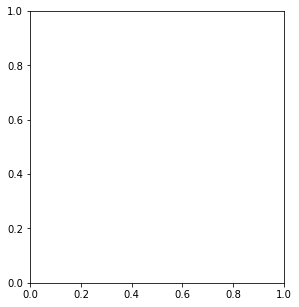

In [15]:
fig = plt.figure(figsize=(10, 5))
stamp_display = []

fig.add_subplot(1,2,1)
stamp_display.append(afwDisplay.Display(frame=fig))
stamp_display[0].scale('linear', 'zscale')
stamp_display[0].mtv(calexp_cutout.maskedImage)

#stamp_display[0].dot('o', x_pix, y_pix, size=4)
for src in calexp_cat:
    stamp_display[0].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
plt.title('Calexp Image and Source Catalog')
    
fig.add_subplot(1,2,2)
stamp_display.append(afwDisplay.Display(frame=fig))
stamp_display[1].scale('linear', 'zscale')
stamp_display[1].mtv(diffexp_cutout.maskedImage)

#stamp_display[1].dot('o', x_pix, y_pix, size=4)
for src in diffexp_cat:
    stamp_display[1].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
    #print(src.getX(), src.getY())
plt.title('Diffexp Image and Source Catalog')

plt.tight_layout()

In [32]:
def return_obj_skycoord(visit_data):
    obj_pos = SkyCoord('%i %i %f %i %i %f' % (visit_data['ra_hour'],
                                              visit_data['ra_min'],
                                              visit_data['ra_sec'],
                                              visit_data['dec_deg'],
                                              visit_data['dec_min'],
                                              visit_data['dec_sec']),
                       unit=(u.hourangle, u.degree))
    
    return obj_pos

In [36]:
calexp.getInfo().getVisitInfo()

VisitInfo(exposureId=41145534, exposureTime=86, darkTime=87.1144, date=2015-02-18T08:15:30.698462000, UT1=nan, ERA=4.73884 rad, boresightRaDec=(147.6200770974, +2.1626720395), boresightAzAlt=(292.8901000000, +30.3700000000), boresightAirmass=1.97, boresightRotAngle=1.5708 rad, rotType=1, observatory=-30.1661N, -70.8149E  2215, weather=Weather(14.1, 77700, 43), instrumentLabel='DECam', id=411455)

In [55]:
visit_time = []
visit_flux = []
visit_flux_err = []
visit_mag = []

ra = 147.33335283600002
dec = 2.12120902375

for obs_idx in range(len(visits)):
    
    # Load data
    visit = visits[obs_idx]
    print(visits)
    calexp = butler.get('calexp', visit= visit, detector= ccd_num, instrument='DECam', collections=collection_calexp)

    diffexp = butler.get('goodSeeingDiff_differenceExp',visit=visit, detector=ccd_num , collections=collection_diff, instrument='DECam')
    diffexp_cat = butler.get('goodSeeingDiff_diaSrc',visit=visit, detector=ccd_num , collections=collection_diff, instrument='DECam')
    exp_visit_info = diffexp.getInfo().getVisitInfo()
    
    # Get Times
    visit_date_python = exp_visit_info.getDate().toPython()
    visit_date_astropy = Time(visit_date_python)
    
    # Match to Difference Image Source Catalog

    obj_pos = SkyCoord(ra*u.deg,dec*u.deg,frame='icrs')
    #obj_pos_lsst = lsst.geom.SpherePoint(obj_pos.ra.deg, obj_pos.dec.deg, lsst.geom.degrees)
    #obj_pos_lsst = lsst.geom.SpherePoint(ra, dec, lsst.geom.degrees)

    #obj_pos = return_obj_skycoord(visit)
    visit_coords = SkyCoord(diffexp_cat['coord_ra']*u.rad,
                            diffexp_cat['coord_dec']*u.rad)
    match_idx, match_sep2d, _ = obj_pos.match_to_catalog_sky(visit_coords)
    
    # Only keep matches with 1 arcsecond. Otherwise skip this visit.
    if match_sep2d.arcsec > 1.0:
        print('No close matches for visit %i. Distance to closest match: %.2f arcsec' % (visit, match_sep2d.arcsec))
        continue
    else:
        print('Match within %.2f arcsec for visit %i' % (match_sep2d.arcsec, visit))
        
    # Load Flux for matched object
    visit_time.append(visit_date_astropy.mjd)
    inst_flux = diffexp_cat.getPsfInstFlux()[match_idx]
    inst_flux_err = diffexp_cat.getPsfInstFluxErr()[match_idx]
    deepDiff_photoCalib = diffexp.getPhotoCalib()
    obj_flux = deepDiff_photoCalib.instFluxToNanojansky(inst_flux, inst_flux_err)
    visit_flux.append(obj_flux.value)
    visit_flux_err.append(obj_flux.error)
    
    # For Exercise 2
    # Load Magnitude for matched object or interesting columns from source catalog or visit information here.

visit_time = np.array(visit_time)

[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411455, 411254, 412059, 412306, 412249, 742512, 742511]
No close matches for visit 410914. Distance to closest match: 56.57 arcsec
[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411455, 411254, 412059, 412306, 412249, 742512, 742511]
No close matches for visit 411054. Distance to closest match: 34.86 arcsec
[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411455, 411254, 412059, 412306, 412249, 742512, 742511]
No close matches for visit 410970. Distance to closest match: 23.09 arcsec
[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411455, 411254, 412059, 412306, 412249, 742512, 742511]
No close matches for visit 411020. Distance to closest match: 17.16 arcsec
[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411455, 411254, 412059, 412306, 412249, 742512, 742511]
No close matches for visit 411354. Distance to closest match: 56.73 arcsec
[410914, 411054, 410970, 411020, 411354, 411405, 411304, 411

In [99]:
for i in butler.registry.queryDatasets("goodSeeingCoadd", collections=collection):
    print(i)

goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 50}, sc=ExposureF] (id=144fd294-10dd-43ac-bb1c-7f226e91c74d)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 85}, sc=ExposureF] (id=e075daf2-7867-4575-be19-1ae6ccfffce4)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 59}, sc=ExposureF] (id=070e579b-3d77-471c-b0a2-023628ac4042)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 75}, sc=ExposureF] (id=f04d3685-40b0-4e9f-a70c-52ff3e50bf42)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 46}, sc=ExposureF] (id=35f26fde-7dba-47e5-a42c-c44fce3b5b11)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 45}, sc=ExposureF] (id=3fb4318b-9c45-4c85-bc04-f502153cfd38)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 36}, sc=ExposureF] (id=a1b1aa27-6c83-4b49-a8dc-23dd70d25019)
goodSeeingCoadd@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 91}, sc=Expos

In [96]:
butler.get("goodSeeingCoadd",dataId ={'band': 'g', 'skymap': 'discrete/hits', 'tract': *, 'patch': *}, collections=collection)

SyntaxError: invalid syntax (1584567746.py, line 1)

In [40]:
butler.registry.queryDatasets("goodSeeingCoadd_nImage@{band: 'g', skymap: 'discrete/hits', tract: 1, patch: 40}, sc=ImageU] (id=ac6cb6f5-e3fb-438d-9119-1f7c4c654ba1)", collections=collection)

In [105]:
coadd = butler.get("goodSeeingCoadd", dataId ={'band': 'g', 'skymap': 'discrete/hits', 'tract': 1, 'patch': 49},detector=36, collections=collection, instrument='DECam')


Text(0.5, 1.0, 'CCD 8')

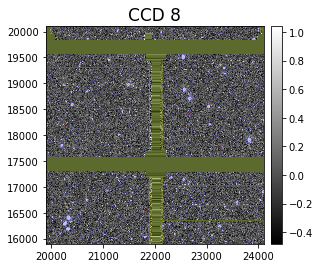

In [93]:
afwDisplay.setDefaultBackend('matplotlib')
display.setMaskTransparency(100)

fig = plt.figure()

#fig.add_subplot(10,10,1) 
display = afwDisplay.Display(frame=fig) 
display.scale('linear', 'zscale') 
display.mtv(coadd) 
plt.title('CCD 8', fontsize=17) 
#plt.axis('off')

Text(0.5, 1.0, 'CCD 8')

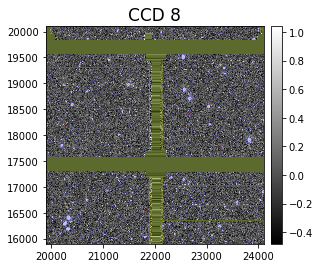

In [68]:
afwDisplay.setDefaultBackend('matplotlib')
display.setMaskTransparency(100)

fig = plt.figure()

#fig.add_subplot(10,10,1) 
display = afwDisplay.Display(frame=fig) 
display.scale('linear', 'zscale') 
display.mtv(coadd) 
plt.title('CCD 8', fontsize=17) 
#plt.axis('off')

In [77]:

calexp_src_cat = butler.get('src', visit= 410891, detector=36, instrument='DECam', collections='processCcdOutputs/Blind15A_02')
calexp = butler.get('calexp', visit= 410891, detector=36, instrument='DECam', collections='processCcdOutputs/Blind15A_02')

In [103]:
skymap = butler.get('skyMap', skymap='discrete/hits', collections='skymaps')
for i in skymap:
    print(i)

TractInfo(id=0)
TractInfo(id=1)
TractInfo(id=2)
TractInfo(id=3)
TractInfo(id=4)
TractInfo(id=5)
TractInfo(id=6)
TractInfo(id=7)
TractInfo(id=8)
TractInfo(id=9)
TractInfo(id=10)
TractInfo(id=11)
TractInfo(id=12)
TractInfo(id=13)
TractInfo(id=14)
TractInfo(id=15)
TractInfo(id=16)
TractInfo(id=17)
TractInfo(id=18)
TractInfo(id=19)
TractInfo(id=20)
TractInfo(id=21)
TractInfo(id=22)
TractInfo(id=23)
TractInfo(id=24)
TractInfo(id=25)
TractInfo(id=26)
TractInfo(id=27)
TractInfo(id=28)
TractInfo(id=29)
TractInfo(id=30)
TractInfo(id=31)
TractInfo(id=32)
TractInfo(id=33)
TractInfo(id=34)
TractInfo(id=35)
TractInfo(id=36)
TractInfo(id=37)
TractInfo(id=38)
TractInfo(id=39)
TractInfo(id=40)
TractInfo(id=41)


Text(0.5, 1.0, 'Calexp Image and Source Catalog')

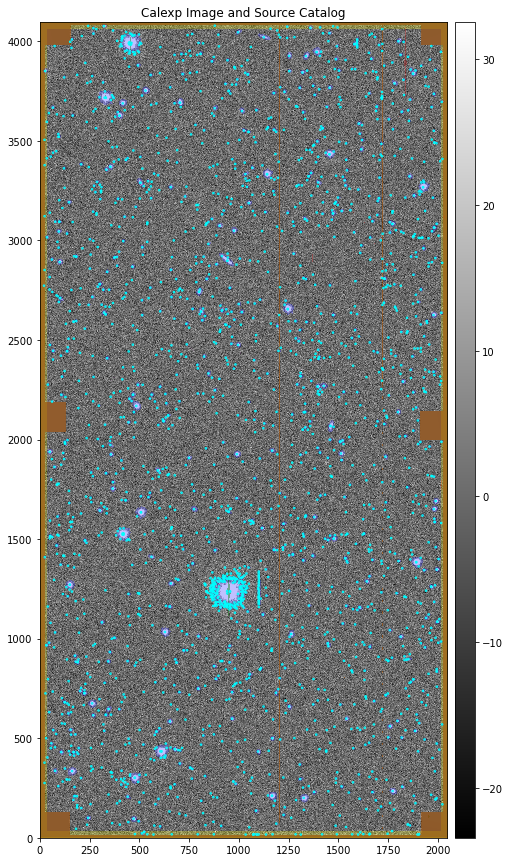

In [89]:

calexp_src_cat
fig = plt.figure(figsize=(15,15))
stamp_display = []
stamp_display.append(afwDisplay.Display(frame=fig))

#fig.add_subplot(10,10,1) 
#display = afwDisplay.Display(frame=fig) 
stamp_display[0].scale('linear', 'zscale') 
stamp_display[0].mtv(calexp)

for src in calexp_src_cat:
    #print(src.getX(), src.getY())
    stamp_display[0].dot('o', src.getX(), src.getY(), ctype='cyan', size=4)
    #plt.Circle((src.getX(), src.getY()),facecolor=None,  edgecolor='cyan', radius=4)

plt.title('Calexp Image and Source Catalog')

In [107]:
help(ImageDifferenceTask.run)

Help on function run in module lsst.pipe.tasks.imageDifference:

run(self, exposure=None, selectSources=None, templateExposure=None, templateSources=None, idFactory=None, calexpBackgroundExposure=None, subtractedExposure=None)
    PSF matches, subtract two images and perform detection on the difference image.
    
    Parameters
    ----------
    exposure : `lsst.afw.image.ExposureF`, optional
        The science exposure, the minuend in the image subtraction.
        Can be None only if ``config.doSubtract==False``.
    selectSources : `lsst.afw.table.SourceCatalog`, optional
        Identified sources on the science exposure. This catalog is used to
        select sources in order to perform the AL PSF matching on stamp images
        around them. The selection steps depend on config options and whether
        ``templateSources`` and ``matchingSources`` specified.
    templateExposure : `lsst.afw.image.ExposureF`, optional
        The template to be subtracted from ``exposure`` in 

In [ ]:
ImageDifferenceTask.run(exposure=calexp, selectSources=calexp_src_cat, )